In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
#import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.patches as patches
import os
import cartopy.mpl.ticker as cticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import re
import matplotlib.colors as mcolors
import datetime
from matplotlib.colors import ListedColormap
from matplotlib.colors import TwoSlopeNorm

In [14]:

#era5 data
ds_era = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/era5/2021.h5')
ds_era
ds_era5_850t_0629= ds_era.fields[716,5,260:40:-1,720:1200]


In [15]:
#ECMWF
directory = '/lsdf/kit/imk-tro/projects/MOD/Gruppe_Grams/nk2448/2023_FourCastNet/Yangfan/validation/'
filename_pattern = r'fc_cf_\d{8}_\d{2}_pl\.nc'

files = sorted([f for f in os.listdir(directory) if re.match(filename_pattern, f)])
files

['fc_cf_20210614_00_pl.nc',
 'fc_cf_20210615_00_pl.nc',
 'fc_cf_20210616_00_pl.nc',
 'fc_cf_20210617_00_pl.nc',
 'fc_cf_20210618_00_pl.nc',
 'fc_cf_20210619_00_pl.nc',
 'fc_cf_20210620_00_pl.nc',
 'fc_cf_20210621_00_pl.nc',
 'fc_cf_20210622_00_pl.nc',
 'fc_cf_20210623_00_pl.nc',
 'fc_cf_20210624_00_pl.nc',
 'fc_cf_20210625_00_pl.nc',
 'fc_cf_20210626_00_pl.nc',
 'fc_cf_20210627_00_pl.nc',
 'fc_cf_20210628_00_pl.nc',
 'fc_cf_20210629_00_pl.nc',
 'fc_cf_20210630_00_pl.nc',
 'fc_cf_20210701_00_pl.nc',
 'fc_cf_20210702_00_pl.nc',
 'fc_cf_20210703_00_pl.nc',
 'fc_cf_20210704_00_pl.nc']

In [7]:
data_ec_t850_1 = []


for file_1 in files[:]:
    file_path_1 = os.path.join(directory, file_1)
    ds_1 = xr.open_dataset(file_path_1)
    variable_data_1 = ds_1['t'][:,1,:,:]
    # Convert to dask array
    #variable_data = da.from_array(variable_data, chunks='auto')
    data_ec_t850_1.append(variable_data_1)

# Now, data_ec contains dask arrays

# You can perform computations on the dask arrays using dask functions
# For example, to compute the mean of the t2m variable across all files:
np.shape(data_ec_t850_1)

(21, 57, 221, 481)

In [8]:
data_ec_t850_1 =xr.DataArray(data_ec_t850_1)

In [9]:
start_index = 56
step_size = 1
num_iterations =15
ec_values=[]
for i in range(num_iterations):
    ec_value =data_ec_t850_1 [(i+1) * step_size, start_index - i * step_size*4,:,:]
    ec_values.append(ec_value)
data_ec_t850_1_values =xr.DataArray(ec_values)
#%store data_array_ec_values_cf
#np.shape(data_array_ec_values)

In [10]:
#fcn_ecmwf
directory_fcn_ec = '/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data/fourcastnet/with_ecmwf_ic/'
filename_pattern_fcn_ec = r'\d{8}_00_backtransformed\.nc'
#fc_cf_20210615_00_sfc.nc
#20210704_00_backtransformed.nc
files_fcn_ec = sorted([f for f in os.listdir(directory_fcn_ec) if re.match(filename_pattern_fcn_ec, f)])
files_fcn_ec

data_fcn_ec = []
for file1 in files_fcn_ec:
    file_path_fcn_ec = os.path.join(directory_fcn_ec, file1)
    # Extract the date from the filename
    date_str = re.search(r'\d{8}', file1).group(0)
    
    date = datetime.datetime.strptime(date_str, '%Y%m%d').date()
    # Read the file and extract the desired variable
    ds_fcn_ec = xr.open_dataset(file_path_fcn_ec)
    variable_data_fcn_ec =  ds_fcn_ec['forecast'][50,:,5,:,:]
    data_fcn_ec.append(variable_data_fcn_ec)

data_array_fcn_ec =xr.DataArray(data_fcn_ec) 

In [11]:

start_index = 56
step_size = 1
num_iterations =15
fcn_ec_values=[]
for i in range(num_iterations):
    fcn_ec_value = data_array_fcn_ec[(i+1) * step_size, start_index - i * step_size*4,:,:]
    fcn_ec_values.append(fcn_ec_value)
data_array_fcn_ec_values =xr.DataArray(fcn_ec_values)
np.shape(data_array_fcn_ec_values)
#data_array_fcn_ec_values[14] = data_array_ec_values[14]
#replace the missing data

(15, 220, 480)

In [12]:
#fcn_era5
ds_fcn_era = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data//fourcastnet/2021_dt_list_ens_backtransformed.nc',engine = 'netcdf4')
ds_fcn_era
mean_fcn_era = ds_fcn_era.forecast[:,0,:,5,:,:]
#mean_fcn_era
start_index = 56
step_size = 1
num_iterations =15
fcn_era_values=[]
for i in range(num_iterations):
    fcn_era_value = mean_fcn_era[(i+1) * step_size, start_index - i * step_size*4,:,:]
    fcn_era_values.append(fcn_era_value)
data_array_fcn_era_values=xr.DataArray(fcn_era_values)

In [13]:
#use smaller batches to calculate the difference(cuz direct calculation is not possible)
variable1_ec_14 = ds_era5_850t_0629.values
variable2_ec_14 = data_ec_t850_1_values[0,221:0:-1,0:480].values
variable3_ec_14 = data_array_fcn_ec_values[0,::-1,:].values
variable4_ec_14 = data_array_fcn_era_values[0,::-1,:].values
np.shape(variable3_ec_14)

#np.shape(variable2_1) 5 
variable1_ec_7 = ds_era5_850t_0629.values
variable2_ec_7 = data_ec_t850_1_values[7,221:0:-1,0:480].values
variable3_ec_7 = data_array_fcn_ec_values[7,::-1,:].values
variable4_ec_7 = data_array_fcn_era_values[7,::-1,:].values

variable1_ec_6 = ds_era5_850t_0629.values
variable2_ec_6 = data_ec_t850_1_values[8,221:0:-1,0:480].values
variable3_ec_6 = data_array_fcn_ec_values[8,::-1,:].values
variable4_ec_6 = data_array_fcn_era_values[8,::-1,:].values

variable1_ec_5 = ds_era5_850t_0629.values
variable2_ec_5 = data_ec_t850_1_values[9,221:0:-1,0:480].values
variable3_ec_5 = data_array_fcn_ec_values[9,::-1,:].values
variable4_ec_5 = data_array_fcn_era_values[9,::-1,:].values

variable1_ec_4 = ds_era5_850t_0629.values
variable2_ec_4 = data_ec_t850_1_values[10,221:0:-1,0:480].values
variable3_ec_4 = data_array_fcn_ec_values[10,::-1,:].values
variable4_ec_4 = data_array_fcn_era_values[10,::-1,:].values



variable1_ec_3 = ds_era5_850t_0629.values
variable2_ec_3 = data_ec_t850_1_values[11,221:0:-1,0:480].values
variable3_ec_3 = data_array_fcn_ec_values[11,::-1,:].values
variable4_ec_3 = data_array_fcn_era_values[11,::-1,:].values


variable1_ec_2 = ds_era5_850t_0629.values
variable2_ec_2 = data_ec_t850_1_values[12,221:0:-1,0:480].values
variable3_ec_2 = data_array_fcn_ec_values[12,::-1,:].values
variable4_ec_2 = data_array_fcn_era_values[12,::-1,:].values


variable1_ec_1 = ds_era5_850t_0629.values
variable2_ec_1 = data_ec_t850_1_values[13,221:0:-1,0:480].values
variable3_ec_1 = data_array_fcn_ec_values[13,::-1,:].values
variable4_ec_1 = data_array_fcn_era_values[13,::-1,:].values


In [14]:
batch_size = 50  # Set the desired batch size

# Process data in smaller batches using a loop

difference_ec_14 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_14 = variable1_ec_14[i:i + batch_size, j:j + batch_size]
        batch_variable2_ec_14 = variable2_ec_14[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_ec_14 =  batch_variable2_ec_14-batch_variable1_ec_14 
        
        # Update the difference array with the current batch_difference
        difference_ec_14[i:i + batch_size, j:j + batch_size] = batch_difference_ec_14

In [15]:
batch_size = 50  # Set the desired batch size

# Process data in smaller batches using a loop

difference_fcn_ec_14 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_14 = variable1_ec_14[i:i + batch_size, j:j + batch_size]
        batch_variable3_ec_14 = variable3_ec_14[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_ec_14 = batch_variable3_ec_14 - batch_variable1_ec_14 
        
        # Update the difference array with the current batch_difference
        difference_fcn_ec_14[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_ec_14

In [16]:
batch_size = 50  # Set the desired batch size

# Process data in smaller batches using a loop

difference_fcn_era_14 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_14 = variable1_ec_14[i:i + batch_size, j:j + batch_size]
        batch_variable4_ec_14 = variable4_ec_14[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_era_14 = batch_variable4_ec_14 - batch_variable1_ec_14 
        
        # Update the difference array with the current batch_difference
        difference_fcn_era_14[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_era_14

In [17]:
difference_ec_7 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_7 = variable1_ec_7[i:i + batch_size, j:j + batch_size]
        batch_variable2_ec_7 = variable2_ec_7[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_ec_7 = batch_variable2_ec_7 - batch_variable1_ec_7 
        
        # Update the difference array with the current batch_difference
        difference_ec_7[i:i + batch_size, j:j + batch_size] = batch_difference_ec_7

In [18]:
difference_fcn_ec_7 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_7 = variable1_ec_7[i:i + batch_size, j:j + batch_size]
        batch_variable3_ec_7 = variable3_ec_7[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_ec_7 = batch_variable3_ec_7 - batch_variable1_ec_7
        
        # Update the difference array with the current batch_difference
        difference_fcn_ec_7[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_ec_7

In [19]:
difference_fcn_era_7 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_7 = variable1_ec_7[i:i + batch_size, j:j + batch_size]
        batch_variable4_ec_7 = variable4_ec_7[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_era_7 = batch_variable4_ec_7 - batch_variable1_ec_7 
        
        # Update the difference array with the current batch_difference
        difference_fcn_era_7[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_era_7

In [20]:
difference_ec_6 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_6 = variable1_ec_6[i:i + batch_size, j:j + batch_size]
        batch_variable2_ec_6 = variable2_ec_6[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_ec_6 = batch_variable2_ec_6 - batch_variable1_ec_6
        
        # Update the difference array with the current batch_difference
        difference_ec_6[i:i + batch_size, j:j + batch_size] = batch_difference_ec_6

difference_fcn_ec_6 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_6 = variable1_ec_6[i:i + batch_size, j:j + batch_size]
        batch_variable3_ec_6 = variable3_ec_6[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_ec_6 = batch_variable3_ec_6 - batch_variable1_ec_6
        
        # Update the difference array with the current batch_difference
        difference_fcn_ec_6[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_ec_6

difference_fcn_era_6 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_6 = variable1_ec_6[i:i + batch_size, j:j + batch_size]
        batch_variable4_ec_6 = variable4_ec_6[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_era_6 = batch_variable4_ec_6 - batch_variable1_ec_6 
        
        # Update the difference array with the current batch_difference
        difference_fcn_era_6[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_era_6

In [21]:
difference_ec_5 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_5 = variable1_ec_5[i:i + batch_size, j:j + batch_size]
        batch_variable2_ec_5 = variable2_ec_5[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_ec_5 = batch_variable2_ec_5 - batch_variable1_ec_5
        
        # Update the difference array with the current batch_difference
        difference_ec_5[i:i + batch_size, j:j + batch_size] = batch_difference_ec_5

difference_fcn_ec_5 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_5 = variable1_ec_5[i:i + batch_size, j:j + batch_size]
        batch_variable3_ec_5 = variable3_ec_5[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_ec_5 = batch_variable3_ec_5 - batch_variable1_ec_5
        
        # Update the difference array with the current batch_difference
        difference_fcn_ec_5[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_ec_5

difference_fcn_era_5 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_5 = variable1_ec_5[i:i + batch_size, j:j + batch_size]
        batch_variable4_ec_5 = variable4_ec_5[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_era_5 = batch_variable4_ec_5 - batch_variable1_ec_5
        
        # Update the difference array with the current batch_difference
        difference_fcn_era_5[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_era_5

In [22]:
difference_ec_4 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_4 = variable1_ec_4[i:i + batch_size, j:j + batch_size]
        batch_variable2_ec_4 = variable2_ec_4[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_ec_4 = batch_variable2_ec_4 - batch_variable1_ec_4
        
        # Update the difference array with the current batch_difference
        difference_ec_4[i:i + batch_size, j:j + batch_size] = batch_difference_ec_4

difference_fcn_ec_4 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_4 = variable1_ec_4[i:i + batch_size, j:j + batch_size]
        batch_variable3_ec_4 = variable3_ec_4[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_ec_4 = batch_variable3_ec_4 - batch_variable1_ec_4
        
        # Update the difference array with the current batch_difference
        difference_fcn_ec_4[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_ec_4

difference_fcn_era_4 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_4= variable1_ec_4[i:i + batch_size, j:j + batch_size]
        batch_variable4_ec_4 = variable4_ec_4[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_era_4 = batch_variable4_ec_4 - batch_variable1_ec_4 
        
        # Update the difference array with the current batch_difference
        difference_fcn_era_4[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_era_4

In [23]:
difference_ec_3 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_3 = variable1_ec_3[i:i + batch_size, j:j + batch_size]
        batch_variable2_ec_3 = variable2_ec_3[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_ec_3 = batch_variable2_ec_3 - batch_variable1_ec_3 
        
        # Update the difference array with the current batch_difference
        difference_ec_3[i:i + batch_size, j:j + batch_size] = batch_difference_ec_3

In [24]:
difference_fcn_ec_3 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_3 = variable1_ec_3[i:i + batch_size, j:j + batch_size]
        batch_variable3_ec_3 = variable3_ec_3[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_ec_3 =  batch_variable3_ec_3 - batch_variable1_ec_3
        
        # Update the difference array with the current batch_difference
        difference_fcn_ec_3[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_ec_3

In [25]:
difference_fcn_era_3 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_3 = variable1_ec_3[i:i + batch_size, j:j + batch_size]
        batch_variable4_ec_3 = variable4_ec_3[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_era_3 = batch_variable4_ec_3 - batch_variable1_ec_3 
        
        # Update the difference array with the current batch_difference
        difference_fcn_era_3[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_era_3

In [26]:
difference_ec_2 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_2 = variable1_ec_2[i:i + batch_size, j:j + batch_size]
        batch_variable2_ec_2 = variable2_ec_2[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_ec_2 = batch_variable2_ec_2 - batch_variable1_ec_2
        
        # Update the difference array with the current batch_difference
        difference_ec_2[i:i + batch_size, j:j + batch_size] = batch_difference_ec_2

difference_fcn_ec_2 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_2 = variable1_ec_2[i:i + batch_size, j:j + batch_size]
        batch_variable3_ec_2 = variable3_ec_2[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_ec_2 = batch_variable3_ec_2 - batch_variable1_ec_2
        
        # Update the difference array with the current batch_difference
        difference_fcn_ec_2[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_ec_2

difference_fcn_era_2 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_2= variable1_ec_2[i:i + batch_size, j:j + batch_size]
        batch_variable4_ec_2 = variable4_ec_2[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_era_2 = batch_variable4_ec_2 - batch_variable1_ec_2 
        
        # Update the difference array with the current batch_difference
        difference_fcn_era_2[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_era_2

In [27]:
difference_ec_1 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_1 = variable1_ec_1[i:i + batch_size, j:j + batch_size]
        batch_variable2_ec_1 = variable2_ec_1[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_ec_1 = batch_variable2_ec_1 - batch_variable1_ec_1
        
        # Update the difference array with the current batch_difference
        difference_ec_1[i:i + batch_size, j:j + batch_size] = batch_difference_ec_1

difference_fcn_ec_1 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_1 = variable1_ec_1[i:i + batch_size, j:j + batch_size]
        batch_variable3_ec_1 = variable3_ec_1[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_ec_1 = batch_variable3_ec_1 - batch_variable1_ec_1
        
        # Update the difference array with the current batch_difference
        difference_fcn_ec_1[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_ec_1

difference_fcn_era_1 = np.empty((220, 480))
for i in range(0, 220, batch_size):
    for j in range(0, 480, batch_size):
        batch_variable1_ec_1= variable1_ec_1[i:i + batch_size, j:j + batch_size]
        batch_variable4_ec_1 = variable4_ec_1[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
        batch_difference_fcn_era_1 = batch_variable4_ec_1 - batch_variable1_ec_1
        
        # Update the difference array with the current batch_difference
        difference_fcn_era_1[i:i + batch_size, j:j + batch_size] = batch_difference_fcn_era_1

In [28]:

lat = np.linspace(25, 80, 220)
lon = np.linspace(-180, -60, 480)
lon_grid, lat_grid = np.meshgrid(lon, lat)
x, y = lon_grid, lat_grid  # Replace with the appropriate transformation method

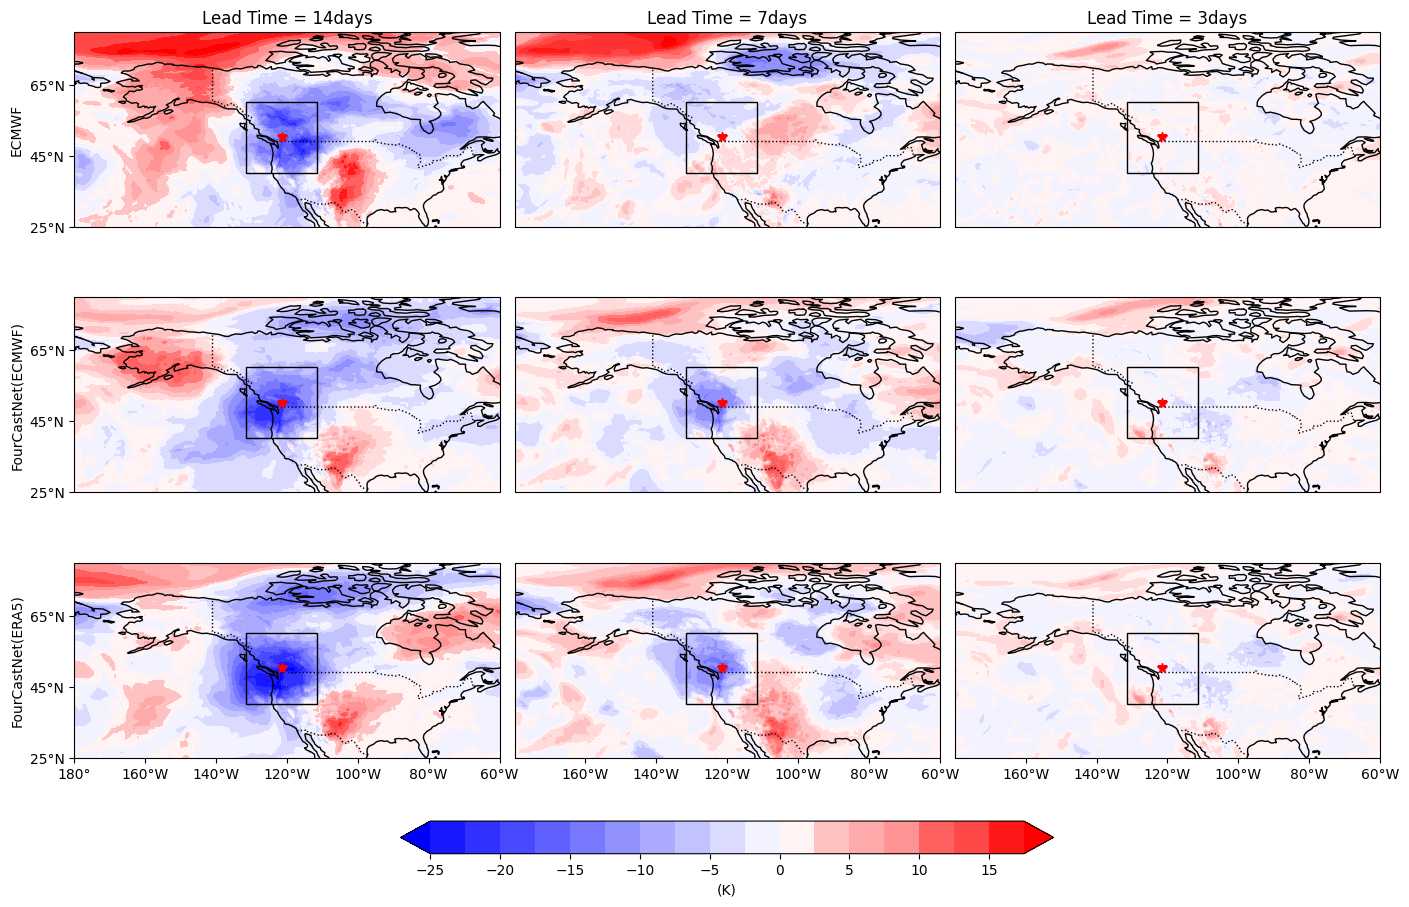

In [26]:
#check if the abnormal sst problem is caused by clor bar settings


#create plots with  DIFFERENCE  9 subplots

# Create a new subplot for additional plots
fig, axs = plt.subplots(3, 3, figsize=(14, 13), subplot_kw={'projection': ccrs.PlateCarree()})



#fig.suptitle('T2m_2021-06-15-18:00UTC', fontsize=12)
#levels = np.linspace(250, 328, 20)
(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) = axs

cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(0, 0, 1), 
                                                          (1, 1., 1), 
                                                          (1, 0, 0)],
                                                 N=22,
                                                 )

vmax = max(difference_ec_14.max(),difference_ec_7.max(), difference_ec_3.max(), difference_fcn_ec_14.max(),difference_fcn_ec_7.max(),difference_fcn_ec_3.max(),difference_fcn_era_14.max(),difference_fcn_era_7.max(),difference_fcn_era_3.max())
vmin = min(difference_ec_14.min(),difference_ec_7.min(), difference_ec_3.min(), difference_fcn_ec_14.min(),difference_fcn_ec_7.min(),difference_fcn_ec_3.min(),difference_fcn_era_14.min(),difference_fcn_era_7.min(),difference_fcn_era_3.min())
#vmax = difference_ec_14.max()
#vmin = difference_ec_14.min()
#cmap = plt.get_cmap('coolwarm')
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
#plot_kwargs = dict(cmap = "coolwarm", vmin=vmin, vmax=vmax,levels = 20)
#norm = mcolors.Normalize(-30,40)
#newcmp = ListedColormap(vals)
#cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue","white","red"])
#cmap = ListedColormap(['red', 'white', 'blue'])
plot_kwargs = dict(cmap=cmap, norm = norm,levels = 20)
#cmap=cmap, norm=norm
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
red_point_lon = -121.50
red_point_lat = 50.25

rect = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_1 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_2 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_3 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_4 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_5 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_6 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_7 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_8 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')





ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax1.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

contour1 = ax1.contourf(x,y,difference_ec_14,**plot_kwargs,extend = 'both')
ax1.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax1.add_patch(rect)
#fourcastnet(ECMWF):FIRST:PERTUBED MEMBERS(50-CONTROL FORECAST),SECOND:LEAD TIME,THIRD:VARIABLES
#phony_dim_2: 21phony_dim_0: 51phony_dim_1: 57phony_dim_3: 220phony_dim_4: 480
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#ax1.set_title('Forecastnet(ECMWF)',loc='left')
ax1.set_title('Lead Time = 14days')
#ax1.set_xlabel('Longitude')
ax1.set_ylabel('ECMWF')



ax2.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax2.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax2.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_title('Lead Time = 7days')
contour2 = ax2.contourf(x,y,difference_ec_7,**plot_kwargs)
ax2.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax2.add_patch(rect_1)
#FRIST DIMENSION:LEAD TIM7
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#ax2.set_title('ECMWF',loc='left')
#ax2.set_title('lead time = +42h',loc='right')
#ax2.set_xlabel('Longitude')
#ax2.set_ylabel('Latitude')

# Add more plots in the second subplot (ax[1])
# Example:
# ax[1].plot(x, y, 'r-', label='Plot 2')
# ax[1].set_xlabel('X-axis')
# ax[1].set_ylabel('Y-axis for Plot 2')



ax3.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS, linestyle=':')
ax3.add_feature(cfeature.LAND, facecolor='lightgray')
ax3.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax3.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax3.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.set_title('Lead Time = 3days')
ax3.plot(red_point_lon, red_point_lat, 'r*', markersize=7)

contour3 = ax3.contourf(x,y,difference_ec_3,**plot_kwargs)
ax3.add_patch(rect_2)
#fourcastnet(ERA5):FIRST:TIME,SECOND:LEAD TIME,THIRD:P2RTURB MEMBERS
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#phony_dim_3: 21phony_dim_0: 21phony_dim_1: 51phony_dim_2: 57phony_dim_4: 220phony_dim_5: 480

#ax3.set_title('Forecastnet(ERA5)',loc='left')
#ax3.set_title('lead time = +42h',loc='right')

#ax3.set_xlabel('Longitude')
#ax3.set_ylabel('Latitude')

ax4.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS, linestyle=':')
ax4.add_feature(cfeature.LAND, facecolor='lightgray')
ax4.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax4.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
contour4 = ax4.contourf(x,y,difference_fcn_ec_14,**plot_kwargs)
ax4.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax4.add_patch(rect_3)
#era5: only first dimension needs to be changed, 2021.06.14:00:00-656
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K orientation='horizontal', shrink=0.5)
#ax4.set_title('ERA5',loc='left')
#ax4.set_xlabel('Longitude')
ax4.set_ylabel('FourCastNet(ECMWF)')
plt.tight_layout()


#cbar = fig.colorbar(contour1, ax=axs, extend = 'both',label='Temperature/K', orientation='vertical',shrink=0.5)
#fig.colorbar(pcm, ax=axs)
#plt.colorbar(ax[1, 0]) 

# Save the combined plot to a file
#plt.savefig('/home/kit/imk-tro/gj5173/plots/t2m_2021-06-15_18:00_changedbar.png', bbox_inches='tight', dpi=100)

# Show the combined plot
#plt.show()

ax5.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.COASTLINE)
ax5.add_feature(cfeature.BORDERS, linestyle=':')
ax5.add_feature(cfeature.LAND, facecolor='lightgray')
ax5.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax5.xaxis.set_major_formatter(lon_formatter)
ax5.yaxis.set_major_formatter(lat_formatter)
contour4 = ax5.contourf(x,y,difference_fcn_ec_7,**plot_kwargs)
ax5.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax5.add_patch(rect_4)
#era5: only first dimension needs to be changed, 2021.06.14:00:00-656
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K orientation='horizontal', shrink=0.5)
#ax4.set_title('ERA5',loc='left')
#ax4.set_xlabel('Longitude')
#ax4.set_ylabel('Latitude')
plt.tight_layout()

ax6.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.COASTLINE)
ax6.add_feature(cfeature.BORDERS, linestyle=':')
ax6.add_feature(cfeature.LAND, facecolor='lightgray')
ax6.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax6.xaxis.set_major_formatter(lon_formatter)
ax6.yaxis.set_major_formatter(lat_formatter)
contour4 = ax6.contourf(x,y,difference_fcn_ec_3,**plot_kwargs)
ax6.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax6.add_patch(rect_5)

ax7.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax7.add_feature(cfeature.COASTLINE)
ax7.add_feature(cfeature.BORDERS, linestyle=':')
ax7.add_feature(cfeature.LAND, facecolor='lightgray')
ax7.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax7.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax7.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax7.xaxis.set_major_formatter(lon_formatter)
ax7.yaxis.set_major_formatter(lat_formatter)
ax7.set_ylabel('FourCastNet(ERA5)')
contour4 = ax7.contourf(x,y,difference_fcn_era_14,**plot_kwargs)
ax7.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax7.add_patch(rect_6)

ax8.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax8.add_feature(cfeature.COASTLINE)
ax8.add_feature(cfeature.BORDERS, linestyle=':')
ax8.add_feature(cfeature.LAND, facecolor='lightgray')
ax8.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax8.set_xticks(np.arange(leftlon+20,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax8.xaxis.set_major_formatter(lon_formatter)
ax8.yaxis.set_major_formatter(lat_formatter)
contour4 = ax8.contourf(x,y,difference_fcn_era_7,**plot_kwargs)
ax8.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax8.add_patch(rect_7)


ax9.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax9.add_feature(cfeature.COASTLINE)
ax9.add_feature(cfeature.BORDERS, linestyle=':')
ax9.add_feature(cfeature.LAND, facecolor='lightgray')
ax9.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax9.set_xticks(np.arange(leftlon+20,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax9.xaxis.set_major_formatter(lon_formatter)
ax9.yaxis.set_major_formatter(lat_formatter)
contour4 = ax9.contourf(x,y,difference_fcn_era_3,**plot_kwargs)
ax9.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax9.add_patch(rect_8)

#norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
#norm = mcolors.TwoSlopeNorm(vcenter=0)
#pc = plt.pcolormesh(axs, norm=norm, cmap=cmap)
#cb = plt.colorbar(pc,orientation='horizontal',shrink=0.5,label='Temperature/K',extend='both')
#cbar.set_ticks()
#cb.add_lines(CS) 
#im = ax9.pcolormesh(x, y, difference_fcn_era_7, cmap=cmap, norm=norm)
#fig.colorbar(im, ax=axs)
#tick_positions = [-abs(vmin), -abs(vmin)/2, 0, abs(vmax)/2, abs(vmax)]
#tick_labels = [f'{val:.1f}' for val in tick_positions]
cbar = plt.colorbar(contour1, ax=axs, orientation='horizontal', cmap=cmap, norm=norm, shrink=0.5,label='(K)',pad = 0.05,extend = 'both')
plt.savefig('/home/kit/imk-tro/gj5173/plots_lead_time_gain/3*3_difference_T850.png', bbox_inches='tight',dpi=100)
#cbar.set_ticklabels(tick_labels)
#plt.colorbar()
#cbar = fig.colorbar(contour1, ax=axs, extend = 'both',label='Temperature/K', orientation='vertical',shrink=0.5)

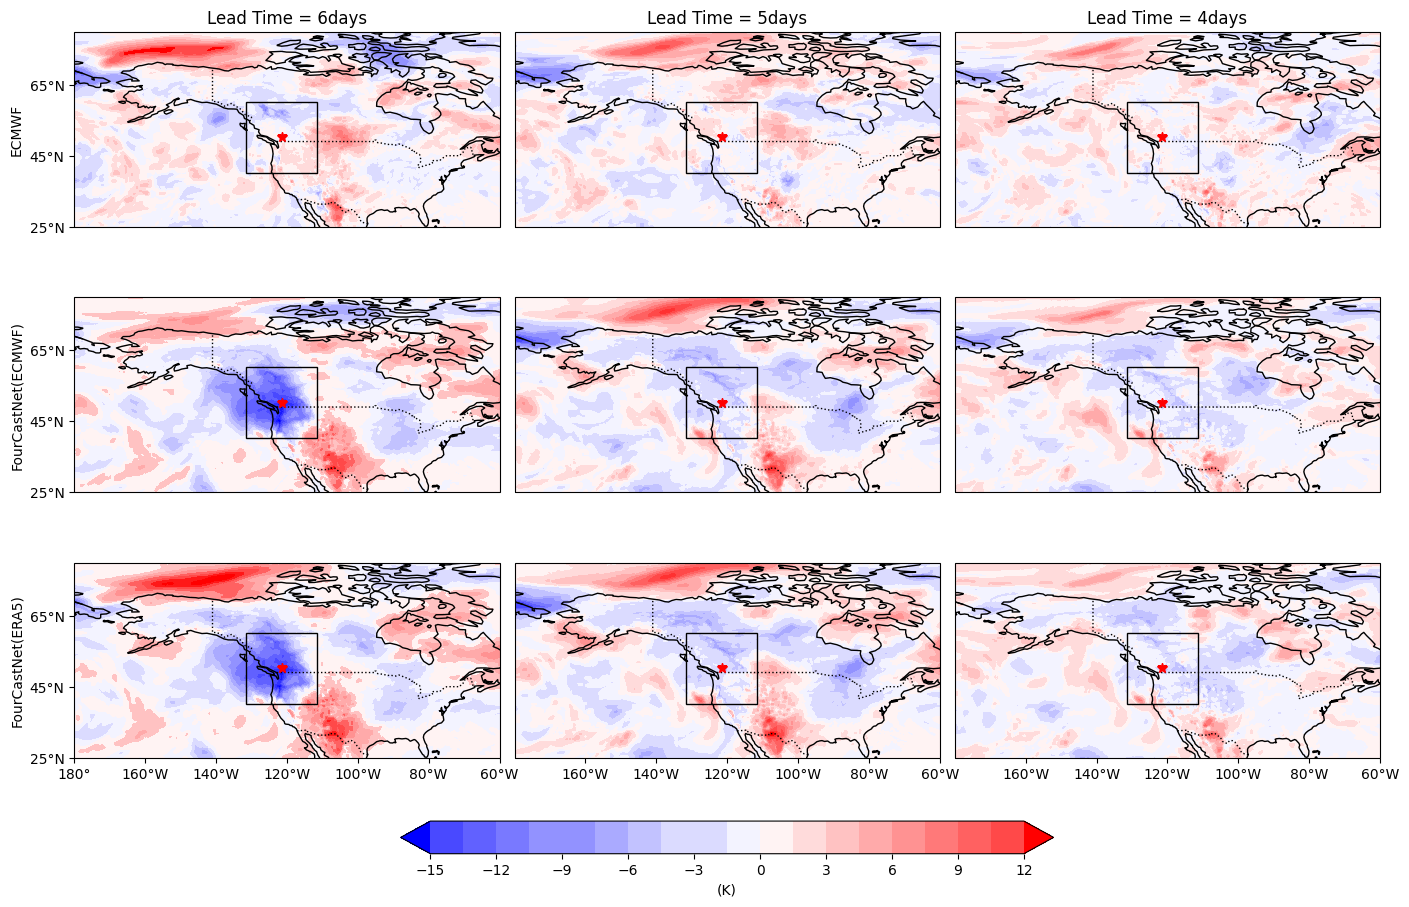

In [27]:
#check if the abnormal sst problem is caused by clor bar settings


#create plots with  DIFFERENCE  9 subplots

# Create a new subplot for additional plots
fig, axs = plt.subplots(3, 3, figsize=(14, 13), subplot_kw={'projection': ccrs.PlateCarree()})



#fig.suptitle('T2m_2021-06-15-18:00UTC', fontsize=12)
#levels = np.linspace(250, 328, 20)
(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) = axs

cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(0, 0, 1), 
                                                          (1, 1., 1), 
                                                          (1, 0, 0)],
                                                 N=22,
                                                 )

vmax = max(difference_ec_6.max(),difference_ec_5.max(), difference_ec_4.max(), difference_fcn_ec_6.max(),difference_fcn_ec_5.max(),difference_fcn_ec_4.max(),difference_fcn_era_6.max(),difference_fcn_era_5.max(),difference_fcn_era_4.max())
vmin = min(difference_ec_6.min(),difference_ec_5.min(), difference_ec_4.min(), difference_fcn_ec_6.min(),difference_fcn_ec_5.min(),difference_fcn_ec_4.min(),difference_fcn_era_6.min(),difference_fcn_era_5.min(),difference_fcn_era_4.min())
#vmax = difference_ec_14.max()
#vmin = difference_ec_14.min()
#cmap = plt.get_cmap('coolwarm')
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
#plot_kwargs = dict(cmap = "coolwarm", vmin=vmin, vmax=vmax,levels = 20)
#norm = mcolors.Normalize(-30,40)
#newcmp = ListedColormap(vals)
#cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue","white","red"])
#cmap = ListedColormap(['red', 'white', 'blue'])
plot_kwargs = dict(cmap=cmap, norm = norm,levels = 20)
#cmap=cmap, norm=norm
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
red_point_lon = -121.50
red_point_lat = 50.25

rect = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_1 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_2 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_3 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_4 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_5 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_6 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_7 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_8 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')





ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax1.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

contour1 = ax1.contourf(x,y,difference_ec_6,**plot_kwargs,extend = 'both')
ax1.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax1.add_patch(rect)
#fourcastnet(ECMWF):FIRST:PERTUBED MEMBERS(50-CONTROL FORECAST),SECOND:LEAD TIME,THIRD:VARIABLES
#phony_dim_2: 21phony_dim_0: 51phony_dim_1: 57phony_dim_3: 220phony_dim_4: 480
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#ax1.set_title('Forecastnet(ECMWF)',loc='left')
ax1.set_title('Lead Time = 6days')
#ax1.set_xlabel('Longitude')
ax1.set_ylabel('ECMWF')



ax2.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax2.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax2.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_title('Lead Time = 5days')
contour2 = ax2.contourf(x,y,difference_ec_5,**plot_kwargs)
ax2.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax2.add_patch(rect_1)
#FRIST DIMENSION:LEAD TIM7
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#ax2.set_title('ECMWF',loc='left')
#ax2.set_title('lead time = +42h',loc='right')
#ax2.set_xlabel('Longitude')
#ax2.set_ylabel('Latitude')

# Add more plots in the second subplot (ax[1])
# Example:
# ax[1].plot(x, y, 'r-', label='Plot 2')
# ax[1].set_xlabel('X-axis')
# ax[1].set_ylabel('Y-axis for Plot 2')



ax3.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS, linestyle=':')
ax3.add_feature(cfeature.LAND, facecolor='lightgray')
ax3.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax3.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax3.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.set_title('Lead Time = 4days')
ax3.plot(red_point_lon, red_point_lat, 'r*', markersize=7)

contour3 = ax3.contourf(x,y,difference_ec_4,**plot_kwargs)
ax3.add_patch(rect_2)
#fourcastnet(ERA5):FIRST:TIME,SECOND:LEAD TIME,THIRD:P2RTURB MEMBERS
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#phony_dim_3: 21phony_dim_0: 21phony_dim_1: 51phony_dim_2: 57phony_dim_4: 220phony_dim_5: 480

#ax3.set_title('Forecastnet(ERA5)',loc='left')
#ax3.set_title('lead time = +42h',loc='right')

#ax3.set_xlabel('Longitude')
#ax3.set_ylabel('Latitude')

ax4.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS, linestyle=':')
ax4.add_feature(cfeature.LAND, facecolor='lightgray')
ax4.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax4.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
contour4 = ax4.contourf(x,y,difference_fcn_ec_6,**plot_kwargs)
ax4.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax4.add_patch(rect_3)
#era5: only first dimension needs to be changed, 2021.06.14:00:00-656
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K orientation='horizontal', shrink=0.5)
#ax4.set_title('ERA5',loc='left')
#ax4.set_xlabel('Longitude')
ax4.set_ylabel('FourCastNet(ECMWF)')
plt.tight_layout()


#cbar = fig.colorbar(contour1, ax=axs, extend = 'both',label='Temperature/K', orientation='vertical',shrink=0.5)
#fig.colorbar(pcm, ax=axs)
#plt.colorbar(ax[1, 0]) 

# Save the combined plot to a file
#plt.savefig('/home/kit/imk-tro/gj5173/plots/t2m_2021-06-15_18:00_changedbar.png', bbox_inches='tight', dpi=100)

# Show the combined plot
#plt.show()

ax5.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.COASTLINE)
ax5.add_feature(cfeature.BORDERS, linestyle=':')
ax5.add_feature(cfeature.LAND, facecolor='lightgray')
ax5.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax5.xaxis.set_major_formatter(lon_formatter)
ax5.yaxis.set_major_formatter(lat_formatter)
contour4 = ax5.contourf(x,y,difference_fcn_ec_5,**plot_kwargs)
ax5.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax5.add_patch(rect_4)
#era5: only first dimension needs to be changed, 2021.06.14:00:00-656
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K orientation='horizontal', shrink=0.5)
#ax4.set_title('ERA5',loc='left')
#ax4.set_xlabel('Longitude')
#ax4.set_ylabel('Latitude')
plt.tight_layout()

ax6.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.COASTLINE)
ax6.add_feature(cfeature.BORDERS, linestyle=':')
ax6.add_feature(cfeature.LAND, facecolor='lightgray')
ax6.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax6.xaxis.set_major_formatter(lon_formatter)
ax6.yaxis.set_major_formatter(lat_formatter)
contour4 = ax6.contourf(x,y,difference_fcn_ec_4,**plot_kwargs)
ax6.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax6.add_patch(rect_5)

ax7.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax7.add_feature(cfeature.COASTLINE)
ax7.add_feature(cfeature.BORDERS, linestyle=':')
ax7.add_feature(cfeature.LAND, facecolor='lightgray')
ax7.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax7.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax7.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax7.xaxis.set_major_formatter(lon_formatter)
ax7.yaxis.set_major_formatter(lat_formatter)
ax7.set_ylabel('FourCastNet(ERA5)')
contour4 = ax7.contourf(x,y,difference_fcn_era_6,**plot_kwargs)
ax7.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax7.add_patch(rect_6)

ax8.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax8.add_feature(cfeature.COASTLINE)
ax8.add_feature(cfeature.BORDERS, linestyle=':')
ax8.add_feature(cfeature.LAND, facecolor='lightgray')
ax8.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax8.set_xticks(np.arange(leftlon+20,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax8.xaxis.set_major_formatter(lon_formatter)
ax8.yaxis.set_major_formatter(lat_formatter)
contour4 = ax8.contourf(x,y,difference_fcn_era_5,**plot_kwargs)
ax8.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax8.add_patch(rect_7)


ax9.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax9.add_feature(cfeature.COASTLINE)
ax9.add_feature(cfeature.BORDERS, linestyle=':')
ax9.add_feature(cfeature.LAND, facecolor='lightgray')
ax9.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax9.set_xticks(np.arange(leftlon+20,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax9.xaxis.set_major_formatter(lon_formatter)
ax9.yaxis.set_major_formatter(lat_formatter)
contour4 = ax9.contourf(x,y,difference_fcn_era_4,**plot_kwargs)
ax9.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax9.add_patch(rect_8)

#norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
#norm = mcolors.TwoSlopeNorm(vcenter=0)
#pc = plt.pcolormesh(axs, norm=norm, cmap=cmap)
#cb = plt.colorbar(pc,orientation='horizontal',shrink=0.5,label='Temperature/K',extend='both')
#cbar.set_ticks()
#cb.add_lines(CS) 
#im = ax9.pcolormesh(x, y, difference_fcn_era_7, cmap=cmap, norm=norm)
#fig.colorbar(im, ax=axs)
#tick_positions = [-abs(vmin), -abs(vmin)/2, 0, abs(vmax)/2, abs(vmax)]
#tick_labels = [f'{val:.1f}' for val in tick_positions]
cbar = plt.colorbar(contour1, ax=axs, orientation='horizontal', cmap=cmap, norm=norm, shrink=0.5,label='(K)',pad = 0.05,extend = 'both')
plt.savefig('/home/kit/imk-tro/gj5173/plots_lead_time_gain/3*3_difference_T850_456.png', bbox_inches='tight',dpi=100)
#cbar.set_ticklabels(tick_labels)
#plt.colorbar()
#cbar = fig.colorbar(contour1, ax=axs, extend = 'both',label='Temperature/K', orientation='vertical',shrink=0.5)

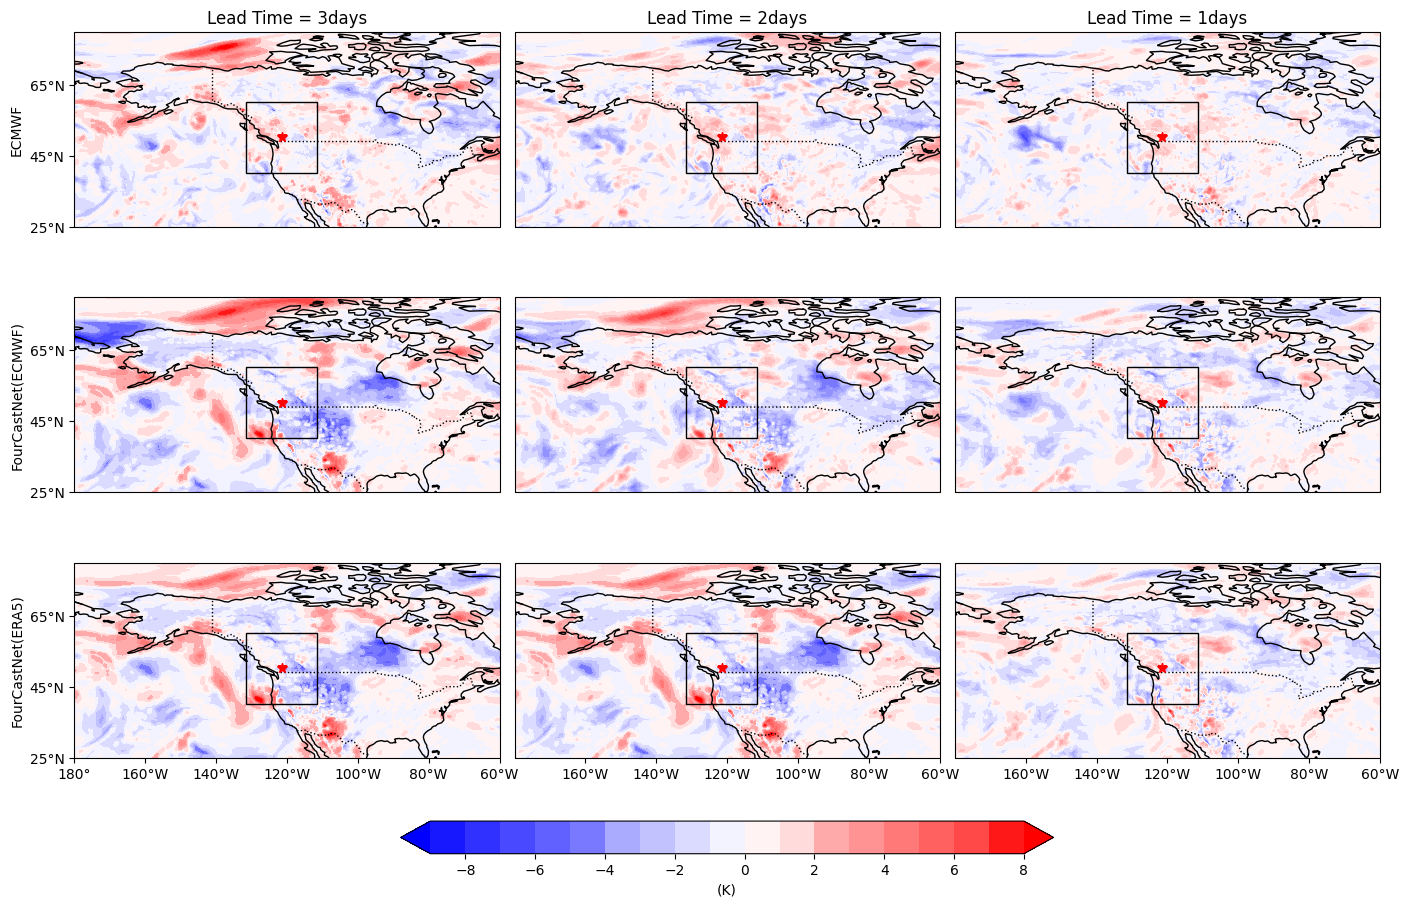

In [33]:
#check if the abnormal sst problem is caused by clor bar settings


#create plots with  DIFFERENCE  9 subplots

# Create a new subplot for additional plots
fig, axs = plt.subplots(3, 3, figsize=(14, 13), subplot_kw={'projection': ccrs.PlateCarree()})



#fig.suptitle('T2m_2021-06-15-18:00UTC', fontsize=12)
#levels = np.linspace(250, 328, 20)
(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) = axs

cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(0, 0, 1), 
                                                          (1, 1., 1), 
                                                          (1, 0, 0)],
                                                 N=22,
                                                 )

vmax = max(difference_ec_3.max(),difference_ec_2.max(), difference_ec_1.max(), difference_fcn_ec_3.max(),difference_fcn_ec_2.max(),difference_fcn_ec_1.max(),difference_fcn_era_3.max(),difference_fcn_era_2.max(),difference_fcn_era_1.max())
vmin = min(difference_ec_3.min(),difference_ec_2.min(), difference_ec_1.min(), difference_fcn_ec_3.min(),difference_fcn_ec_2.min(),difference_fcn_ec_1.min(),difference_fcn_era_3.min(),difference_fcn_era_2.min(),difference_fcn_era_1.min())
#vmax = difference_ec_14.max()
#vmin = difference_ec_14.min()
#cmap = plt.get_cmap('coolwarm')
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
#plot_kwargs = dict(cmap = "coolwarm", vmin=vmin, vmax=vmax,levels = 20)
#norm = mcolors.Normalize(-30,40)
#newcmp = ListedColormap(vals)
#cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue","white","red"])
#cmap = ListedColormap(['red', 'white', 'blue'])
plot_kwargs = dict(cmap=cmap, norm = norm,levels = 20)
#cmap=cmap, norm=norm
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
red_point_lon = -121.50
red_point_lat = 50.25

rect = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_1 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_2 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_3 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_4 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_5 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_6 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_7 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')
rect_8 = patches.Rectangle((-131.5,40.25),20,20, linewidth=1, edgecolor='black', facecolor='none')





ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAND, facecolor='lightgray')
ax1.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax1.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

contour1 = ax1.contourf(x,y,difference_ec_3,**plot_kwargs,extend = 'both')
ax1.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax1.add_patch(rect)
#fourcastnet(ECMWF):FIRST:PERTUBED MEMBERS(50-CONTROL FORECAST),SECOND:LEAD TIME,THIRD:VARIABLES
#phony_dim_2: 21phony_dim_0: 51phony_dim_1: 57phony_dim_3: 220phony_dim_4: 480
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#ax1.set_title('Forecastnet(ECMWF)',loc='left')
ax1.set_title('Lead Time = 3days')
#ax1.set_xlabel('Longitude')
ax1.set_ylabel('ECMWF')



ax2.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.add_feature(cfeature.LAND, facecolor='lightgray')
ax2.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax2.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax2.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.set_title('Lead Time = 2days')
contour2 = ax2.contourf(x,y,difference_ec_2,**plot_kwargs)
ax2.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax2.add_patch(rect_1)
#FRIST DIMENSION:LEAD TIM7
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#ax2.set_title('ECMWF',loc='left')
#ax2.set_title('lead time = +42h',loc='right')
#ax2.set_xlabel('Longitude')
#ax2.set_ylabel('Latitude')

# Add more plots in the second subplot (ax[1])
# Example:
# ax[1].plot(x, y, 'r-', label='Plot 2')
# ax[1].set_xlabel('X-axis')
# ax[1].set_ylabel('Y-axis for Plot 2')



ax3.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS, linestyle=':')
ax3.add_feature(cfeature.LAND, facecolor='lightgray')
ax3.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax3.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax3.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.set_title('Lead Time = 1days')
ax3.plot(red_point_lon, red_point_lat, 'r*', markersize=7)

contour3 = ax3.contourf(x,y,difference_ec_1,**plot_kwargs)
ax3.add_patch(rect_2)
#fourcastnet(ERA5):FIRST:TIME,SECOND:LEAD TIME,THIRD:P2RTURB MEMBERS
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K', orientation='horizontal', shrink=0.5)
#phony_dim_3: 21phony_dim_0: 21phony_dim_1: 51phony_dim_2: 57phony_dim_4: 220phony_dim_5: 480

#ax3.set_title('Forecastnet(ERA5)',loc='left')
#ax3.set_title('lead time = +42h',loc='right')

#ax3.set_xlabel('Longitude')
#ax3.set_ylabel('Latitude')

ax4.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS, linestyle=':')
ax4.add_feature(cfeature.LAND, facecolor='lightgray')
ax4.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax4.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
contour4 = ax4.contourf(x,y,difference_fcn_ec_3,**plot_kwargs)
ax4.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax4.add_patch(rect_3)
#era5: only first dimension needs to be changed, 2021.06.14:00:00-656
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K orientation='horizontal', shrink=0.5)
#ax4.set_title('ERA5',loc='left')
#ax4.set_xlabel('Longitude')
ax4.set_ylabel('FourCastNet(ECMWF)')
plt.tight_layout()


#cbar = fig.colorbar(contour1, ax=axs, extend = 'both',label='Temperature/K', orientation='vertical',shrink=0.5)
#fig.colorbar(pcm, ax=axs)
#plt.colorbar(ax[1, 0]) 

# Save the combined plot to a file
#plt.savefig('/home/kit/imk-tro/gj5173/plots/t2m_2021-06-15_18:00_changedbar.png', bbox_inches='tight', dpi=100)

# Show the combined plot
#plt.show()

ax5.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.COASTLINE)
ax5.add_feature(cfeature.BORDERS, linestyle=':')
ax5.add_feature(cfeature.LAND, facecolor='lightgray')
ax5.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax5.xaxis.set_major_formatter(lon_formatter)
ax5.yaxis.set_major_formatter(lat_formatter)
contour4 = ax5.contourf(x,y,difference_fcn_ec_2,**plot_kwargs)
ax5.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax5.add_patch(rect_4)
#era5: only first dimension needs to be changed, 2021.06.14:00:00-656
#cbar = plt.colorbar(contour, ax=ax[0], label='Temperature/K orientation='horizontal', shrink=0.5)
#ax4.set_title('ERA5',loc='left')
#ax4.set_xlabel('Longitude')
#ax4.set_ylabel('Latitude')
plt.tight_layout()

ax6.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.COASTLINE)
ax6.add_feature(cfeature.BORDERS, linestyle=':')
ax6.add_feature(cfeature.LAND, facecolor='lightgray')
ax6.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
#ax4.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax6.xaxis.set_major_formatter(lon_formatter)
ax6.yaxis.set_major_formatter(lat_formatter)
contour4 = ax6.contourf(x,y,difference_fcn_ec_1,**plot_kwargs)
ax6.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax6.add_patch(rect_5)

ax7.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax7.add_feature(cfeature.COASTLINE)
ax7.add_feature(cfeature.BORDERS, linestyle=':')
ax7.add_feature(cfeature.LAND, facecolor='lightgray')
ax7.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax7.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax7.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax7.xaxis.set_major_formatter(lon_formatter)
ax7.yaxis.set_major_formatter(lat_formatter)
ax7.set_ylabel('FourCastNet(ERA5)')
contour4 = ax7.contourf(x,y,difference_fcn_era_3,**plot_kwargs)
ax7.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax7.add_patch(rect_6)

ax8.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax8.add_feature(cfeature.COASTLINE)
ax8.add_feature(cfeature.BORDERS, linestyle=':')
ax8.add_feature(cfeature.LAND, facecolor='lightgray')
ax8.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax8.set_xticks(np.arange(leftlon+20,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax8.xaxis.set_major_formatter(lon_formatter)
ax8.yaxis.set_major_formatter(lat_formatter)
contour4 = ax8.contourf(x,y,difference_fcn_era_3,**plot_kwargs)
ax8.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax8.add_patch(rect_7)


ax9.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
ax9.add_feature(cfeature.COASTLINE)
ax9.add_feature(cfeature.BORDERS, linestyle=':')
ax9.add_feature(cfeature.LAND, facecolor='lightgray')
ax9.add_feature(cfeature.OCEAN, facecolor='w')
leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent
ax9.set_xticks(np.arange(leftlon+20,rightlon+10,20), crs=ccrs.PlateCarree())
#ax5.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()
ax9.xaxis.set_major_formatter(lon_formatter)
ax9.yaxis.set_major_formatter(lat_formatter)
contour4 = ax9.contourf(x,y,difference_fcn_era_1,**plot_kwargs)
ax9.plot(red_point_lon, red_point_lat, 'r*', markersize=7)
ax9.add_patch(rect_8)

#norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
#norm = mcolors.TwoSlopeNorm(vcenter=0)
#pc = plt.pcolormesh(axs, norm=norm, cmap=cmap)
#cb = plt.colorbar(pc,orientation='horizontal',shrink=0.5,label='Temperature/K',extend='both')
#cbar.set_ticks()
#cb.add_lines(CS) 
#im = ax9.pcolormesh(x, y, difference_fcn_era_7, cmap=cmap, norm=norm)
#fig.colorbar(im, ax=axs)
#tick_positions = [-abs(vmin), -abs(vmin)/2, 0, abs(vmax)/2, abs(vmax)]
#tick_labels = [f'{val:.1f}' for val in tick_positions]
cbar = plt.colorbar(contour1, ax=axs, orientation='horizontal', cmap=cmap, norm=norm, shrink=0.5,label='(K)',pad = 0.05,extend = 'both')
plt.savefig('/home/kit/imk-tro/gj5173/plots_lead_time_gain/3*3_difference_T850_321.png', bbox_inches='tight',dpi=100)
#cbar.set_ticklabels(tick_labels)
#plt.colorbar()
#cbar = fig.colorbar(contour1, ax=axs, extend = 'both',label='Temperature/K', orientation='vertical',shrink=0.5)

In [3]:
%store -r anomaly_fc_era_t850_cf 
%store -r anomaly_fc_era_t850_pf 
%store -r anomaly_fc_ec_t850_cf 
%store -r anomaly_fc_ec_t850_pf
%store -r anomaly_fc_era_t850
%store -r anomaly_era5_t850
%store -r anomaly_fc_ec_t850

In [18]:
%store -r anomaly_fc_era_t850

no stored variable or alias anomaly_fc_era_t850


Text(0, 0.5, 'Latitude')

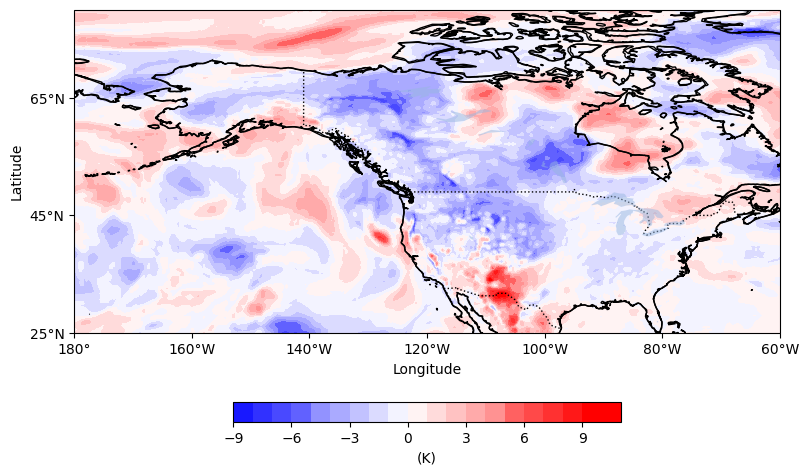

In [31]:

#fig, axs = plt.subplots(3, 3, figsize=(14, 13), subplot_kw={'projection': ccrs.PlateCarree()})



#fig.suptitle('T2m_2021-06-15-18:00UTC', fontsize=12)
#levels = np.linspace(250, 328, 20)
#(ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9) = axs

cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(0, 0, 1), 
                                                          (1, 1., 1), 
                                                          (1, 0, 0)],
                                                 N=22,
                                                 )
norm = TwoSlopeNorm(vmin=-10, vcenter=0, vmax=10)
#plot_kwargs = dict(cmap = "coolwarm", vmin=vmin, vmax=vmax,levels = 20)
#norm = mcolors.Normalize(-30,40)
#newcmp = ListedColormap(vals)
#cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue","white","red"])
#cmap = ListedColormap(['red', 'white', 'blue'])
plot_kwargs = dict(cmap=cmap, norm = norm,levels = 20)
#cmap=cmap, norm=norm

lat = np.linspace(25, 80,220)
lon = np.linspace(-180, -60, 480)
lon_grid, lat_grid = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(10,6))
#proj = ccrs.PlateCarree(central_longitude=-120)
#ax = fig.add_axes([0.1, 0.8, 0.5, 0.3],projection = proj)
ax = plt.axes(projection=ccrs.PlateCarree())

x, y = lon_grid, lat_grid  # Replace with the appropriate transformation method

leftlon, rightlon, lowerlat, upperlat = (-180,-60,25,80)#define map extent

#f2_ax1 = fig.add_axes([0.1, 0.8, 0.5, 0.3],projection = proj)
ax.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
                  


# Add map 
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='w')


ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.set_xticks(np.arange(leftlon,rightlon+10,20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(lowerlat,upperlat,20), crs=ccrs.PlateCarree())

lat_formatter = cticker.LatitudeFormatter()
lon_formatter = cticker.LongitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
#contour_levels = np.linspace(0, 20, 11)
# Plot the contour map
#contour = ax.contourf(lon,lat,ds_era.fields[656,2,260:40:-1,720:1200],cmap='jet',levels=20)
#contour1 = ax.contourf(x,y,difference_fcn_era_4-difference_fcn_ec_4,**plot_kwargs)
contour1 = ax.contourf(x,y,anomaly_fc_era_t850[],**plot_kwargs)

#mark the location of lytto
#red_point_lon = -121.50
#red_point_lat = 50.25
#ax.plot(red_point_lon, red_point_lat, 'r*', markersize=10)
# Add colorbar
#plt.colorbar
vmin=0
vmax=25
cbar = plt.colorbar(contour1, ax=ax, label='(K)',orientation='horizontal',shrink=0.5)


# Set plot title and labels
#plt.title('T850_FCN_ERA_member49')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#plt.savefig('/home/kit/imk-tro/gj5173/anomaly_fcn_era_later /FCN_ERA_49.png')

#656:2021.06.14 00UTC -06.29 00UTC

# Show the plot
#plt.show()

In [2]:
#fcn_era5
ds_fcn_era = xr.open_dataset('/lsdf/kit/imk-tro/projects/MOD/Gruppe_Knippertz/ey9908/tmp_Yangfan/data//fourcastnet/2021_dt_list_ens_backtransformed.nc',engine = 'netcdf4')
ds_fcn_era
fcn_era_z = ds_fcn_era.forecast[:,:,:,5,:,:]

In [3]:
variable_data_ec_1 = fcn_era_z[1,:,56,:,:]


variable_data_ec_2 = fcn_era_z[2,:,52,:,:]
#mean_fcn_ec_1 = np.mean(variable_data_fcn_ec_1, axis=(-2, -1))


variable_data_ec_3 = fcn_era_z[3,:,48,:,:]

variable_data_ec_4 = fcn_era_z[4,:,44,:,:]

variable_data_ec_5 = fcn_era_z[5,:,40,:,:]

variable_data_ec_6 = fcn_era_z[6,:,36,:,:]

variable_data_ec_7 = fcn_era_z[7,:,32,:,:]

variable_data_ec_8 = fcn_era_z[8,:,28,:,:]

variable_data_ec_9 = fcn_era_z[9,:,24,:,:]

variable_data_ec_10 = fcn_era_z[10,:,20,:,:]

variable_data_ec_11 = fcn_era_z[12,:,16,:,:]

variable_data_ec_12 = fcn_era_z[13,:,12,:,:]

variable_data_ec_13 = fcn_era_z[14,:,8,:,:]

variable_data_ec_14 = fcn_era_z[15,:,4,:,:]

variable_data_ec_15 = fcn_era_z[16,:,0,:,:]

In [4]:
new_dimension = 'time'
ds_ec_1_expanded = variable_data_ec_1.expand_dims(**{new_dimension: [0]})
ds_ec_2_expanded = variable_data_ec_2.expand_dims(**{new_dimension: [1]})
ds_ec_3_expanded = variable_data_ec_3.expand_dims(**{new_dimension: [2]})
ds_ec_4_expanded = variable_data_ec_4.expand_dims(**{new_dimension: [3]})
ds_ec_5_expanded = variable_data_ec_5.expand_dims(**{new_dimension: [4]})
ds_ec_6_expanded = variable_data_ec_6.expand_dims(**{new_dimension: [5]})
ds_ec_7_expanded = variable_data_ec_7.expand_dims(**{new_dimension: [6]})
ds_ec_8_expanded = variable_data_ec_8.expand_dims(**{new_dimension: [7]})
ds_ec_9_expanded = variable_data_ec_9.expand_dims(**{new_dimension: [8]})
ds_ec_10_expanded = variable_data_ec_10.expand_dims(**{new_dimension:[9]})
ds_ec_11_expanded = variable_data_ec_11.expand_dims(**{new_dimension: [10]})
ds_ec_12_expanded = variable_data_ec_12.expand_dims(**{new_dimension: [11]})
ds_ec_13_expanded = variable_data_ec_13.expand_dims(**{new_dimension: [12]})
ds_ec_14_expanded = variable_data_ec_14.expand_dims(**{new_dimension: [13]})
ds_ec_15_expanded = variable_data_ec_15.expand_dims(**{new_dimension: [14]})

In [5]:
ds_fc_era_t850 = xr.concat([ds_ec_1_expanded,ds_ec_2_expanded,ds_ec_3_expanded,ds_ec_4_expanded,ds_ec_5_expanded,ds_ec_6_expanded,ds_ec_7_expanded,ds_ec_8_expanded,ds_ec_9_expanded,ds_ec_10_expanded,ds_ec_11_expanded,ds_ec_12_expanded,ds_ec_13_expanded,ds_ec_14_expanded,ds_ec_15_expanded],dim=new_dimension)

/home/kit/imk-tro/gj5173/anaconda3/envs/newenvi1/lib/python3.9/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [6]:
original_data = ds_fc_era_t850[:,:,:,:]

In [7]:
ds_fc_era_t850_interpolated = np.zeros((15,51,110,240),dtype=float)

In [1]:

%store  -r anomaly_fc_era_t850
%store  -r anomaly_fc_ec_t850

In [12]:
#clim_t850 = xr.open_dataset('/home/kit/imk-tro/gj5173/tmp/clim_T85000_30day_centered_on_0629_1979-2020_-180.0--60.0degE_25.0-80.0degN_by_grid_point',engine = 'netcdf4')

In [10]:
#use smaller batches to calculate the difference(cuz direct calculation is not possible)
variable1 = ds_fc_era_t850_interpolated[:,:,::-1,:]
variable2 = clim_t850.T[:,:].values


batch_size = 50  # Set the desired batch size

# Process data in smaller batches using a loop

anomaly_fc_era_t850 = np.empty((15,51,110,240))

for i in range(0, 110, batch_size):
    for j in range(0, 240, batch_size):
        for k in range(15):
            for l in range(51):
                batch_variable1 = variable1[k,l,i:i + batch_size, j:j + batch_size]
                batch_variable2 = variable2[i:i + batch_size, j:j + batch_size]
        
        # Calculate the difference point by point for the current batch
                batch_difference = batch_variable1 - batch_variable2
        
        # Update the difference array with the current batch_difference
                anomaly_fc_era_t850[k,l,i:i + batch_size, j:j + batch_size] = batch_difference

NameError: name 'clim_t850' is not defined